In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# 1 stage

In [2]:
features = pd.read_csv('./features.csv', index_col='match_id')
pd.options.display.max_columns = None
arr_feat_loss = []
feat_droped = features.drop(['duration','radiant_win','tower_status_radiant','tower_status_dire','barracks_status_radiant','barracks_status_dire'], axis=1)
for i, name_fe in enumerate(features.columns):
    if (features.count()[i] < len(features.index)): 
        arr_feat_loss.append(name_fe)
print(arr_feat_loss)
feat_droped = feat_droped.fillna(0)
print('radiant_win')

['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']
radiant_win


In [14]:
# select all rows
#X_0 = feat_droped # selected wished features
#y_0 = features['radiant_win'] # selected target

# randomize select rows
r = np.random.randint(len(features.index),size=5000)
X_0 = feat_droped.iloc[r,:]
y_0 = features['radiant_win'].iloc[r]

In [15]:
# additional prepare data
unique = np.unique(X_0[['r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero']].values) # unique users
#print(len(pd.value_counts(X_0['rXXX_hero']))) # different types
X_1 = X_0.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero'], axis=1)
#X_1 = X_0.drop(['lobby_type'], axis=1)
scaler = StandardScaler()
X_2 = pd.DataFrame(scaler.fit_transform(X_1), index=X_1.index, columns=X_1.columns) # convert there and back

# N — количество различных героев в выборке
N = 113
X_pick = np.zeros((X_0.shape[0], N))
for i, match_id in tqdm_notebook(enumerate(X_0.index)):
    for p in range(5):
        X_pick[i, X_0.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_0.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_p = pd.DataFrame(X_pick, index=X_1.index)
X_0 = pd.concat([X_2, X_p], axis=1, join_axes=[X_2.index]) # add to DataFrame
#display(X_0)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [ ]:
# calculate for different number trees
n_ras = [] # array values auc-roc per n_trees
start_time = datetime.datetime.now() # fstart calculate time
for n_trees in tqdm_notebook(np.arange(10,100,10)):
    gbc = GradientBoostingClassifier(n_estimators=n_trees, max_depth=1)
    kf = KFold(n_splits=5, shuffle=True)
    ras = [] # array values auc-roc into KFold
    for train_index, test_index in tqdm_notebook(kf.split(X_0)):
        X_train, X_test = X_0.values[train_index], X_0.values[test_index]
        y_train, y_test = y_0.values[train_index], y_0.values[test_index]
        gbc.fit(X_train, y_train)
        y_scores = gbc.predict_proba(X_test)[:, 1]
        ras.append(roc_auc_score(y_test, y_scores, average='samples'))
    n_ras.append(np.mean(ras))
print('Time elapsed:', datetime.datetime.now() - start_time) # stop calculate time    
print(n_ras)
plt.title('array values auc-roc per n_trees', color='yellow')
plt.rc('axes',edgecolor='yellow')
plt.rcParams['xtick.color'] = 'yellow'
plt.rcParams['ytick.color'] = 'yellow'
plt.plot(np.arange(10,100,10),n_ras) # for line
plt.legend(['auc-roc'], loc='upper left')
plt.grid(True)

In [ ]:
# calculate time for 30 trees
start_time = datetime.datetime.now() # fstart calculate time
gbc = GradientBoostingClassifier(n_estimators=30)
kf = KFold(n_splits=5, shuffle=True)
ras = [] # array values auc-roc into KFold
for train_index, test_index in tqdm_notebook(kf.split(X_0)):
    X_train, X_test = X_0.values[train_index], X_0.values[test_index]
    y_train, y_test = y_0.values[train_index], y_0.values[test_index]
    gbc.fit(X_train, y_train)
    y_scores = gbc.predict_proba(X_test)[:, 1]
    ras.append(roc_auc_score(y_test, y_scores, average='samples'))
print('Time elapsed for 30 trees:', datetime.datetime.now() - start_time) # stop calculate time    
print('Score AUC-ROC: ', np.mean(ras))


In [ ]:
Отчёт_1:
1. пропуски имеют следующие признаки: 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'.
(?)Я хз, что они могут означать...
2. Целевую переменную содержит столбец 'radiant_win'
3. Time elapsed for 30 trees: 0:01:23.987412 ; Score AUC-ROC:  0.6893316710163322 (взята полная выборка объектов)
4. Если применять градиентный бустинг к данной задаче, то при увеличении числа деревьев качество всё время повышается 
(в цикле от 10 до 90 деревьев оптимум не достигнут). Делать больше, чем 30 деревьев смысл есть, и для ускорения работы
алгоритма можно попробовать понизить размерность матрицы признаков, упростить модель, брать лишь часть объектов 
для обучения. Для данного анализа была случайно отобрана треть выборки, длительность расчёта - 'Time elapsed: 0:05:31.306915'

In [ ]:
# 2 stage

In [9]:
# Logistic Regression (without change paramrter C)
logreg = LogisticRegression(penalty='l2', C=1e3, solver='liblinear')
start_time = datetime.datetime.now() # fstart calculate time
kf = KFold(n_splits=5, shuffle=True)
ras = [] # array values auc-roc into KFold
for train_index, test_index in tqdm_notebook(kf.split(X_0)):
    X_train, X_test = X_0.values[train_index], X_0.values[test_index]
    y_train, y_test = y_0.values[train_index], y_0.values[test_index]
    logreg.fit(X_train, y_train)
    y_scores = logreg.predict_proba(X_test)[:, 1]
    ras.append(roc_auc_score(y_test, y_scores, average='samples'))
print('Time elapsed for 30 trees:', datetime.datetime.now() - start_time) # stop calculate time    
print('Score AUC-ROC: ', np.mean(ras))


Time elapsed for 30 trees: 0:00:16.596656
Score AUC-ROC:  0.7461863913536433


In [ ]:
# Logistic Regression (with change parameter C)
n_ras = [] # array values auc-roc per param
start_time = datetime.datetime.now() # fstart calculate time
start_par = 1
stop_par = 1e5
step_par = 1e2
for param in tqdm_notebook(np.arange(start_par,stop_par,step_par)):
    logreg = LogisticRegression(penalty='l2', C=param, solver='liblinear')
    kf = KFold(n_splits=5, shuffle=True)
    ras = [] # array values auc-roc into KFold
    for train_index, test_index in kf.split(X_0):
        X_train, X_test = X_0.values[train_index], X_0.values[test_index]
        y_train, y_test = y_0.values[train_index], y_0.values[test_index]
        logreg.fit(X_train, y_train)
        y_scores = logreg.predict_proba(X_test)[:, 1]
        ras.append(roc_auc_score(y_test, y_scores, average='samples'))
    n_ras.append(np.mean(ras))
print('Time elapsed:', datetime.datetime.now() - start_time) # stop calculate time    
#print(n_ras)
plt.title('array values auc-roc per param', color='yellow')
plt.rc('axes',edgecolor='yellow')
plt.rcParams['xtick.color'] = 'yellow'
plt.rcParams['ytick.color'] = 'yellow'
plt.plot(np.arange(start_par,stop_par,step_par),n_ras) # for line
plt.legend(['auc-roc'], loc='upper left')
plt.grid(True)

In [13]:
n_ras_1 = n_ras

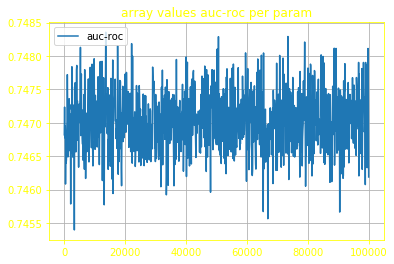

In [11]:
plt.title('array values auc-roc per param', color='yellow')
plt.rc('axes',edgecolor='yellow')
plt.rcParams['xtick.color'] = 'yellow'
plt.rcParams['ytick.color'] = 'yellow'
plt.plot(np.arange(start_par,stop_par,step_par),n_ras) # for line
plt.legend(['auc-roc'], loc='upper left')
plt.grid(True)

In [ ]:
Отчёт_2: